In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Load AMS LaTeX font in matplotlib.pyplot
plt.rc('mathtext', fontset="cm")
plt.rcParams.update({
'font.size': 12,
'text.usetex': True,
'text.latex.preamble': r'\usepackage{amsfonts}'
})

# Import local modules

from utils import get_tail_from_pds
from RBM import RBM
from copulas import GaussianCopula
from utils import toy_dataset

2023-04-15 12:17:50.770844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 12:17:50.893157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-15 12:17:50.893177: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-15 12:17:51.585866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Simulating and calibrating copula models

In [ ]:
# Generate synthetic multi-factor Gaussian copula dataset of default probabilities (PDs)

n_debtors = 300
n_factors = 50
n_samples = 10000

avg_pds = tf.random.uniform([n_debtors], minval=0., maxval=0.05)
coefs = tf.random.uniform([n_debtors, n_factors], minval=0., maxval=1/(2*np.sqrt(n_factors)))

GC_model_true = GaussianCopula(avg_pds=avg_pds, coefs=coefs)
pds_true = GC_model_true.simulate_pds(n_samples)

In [ ]:
# Calibrate a new multi-factor Gaussian copula model on the synthetic dataset

GC_model_est = GaussianCopula()
GC_model_est.fit(pds_true, n_factors=n_factors, verbose=True)

In [ ]:
# Generate a dataset of PDs from the calibrated model

pds_est = GC_model_est.simulate_pds(n_samples)

In [ ]:
# Compare the calibrated model with the true model using histograms of marginal distributions

labels = ['True model', 'Estimated model']
colors = ['red', 'blue']

obligor_id = 10
n_bins = 200

for i_pds, pds in enumerate([pds_true, pds_est]):
    plt.hist(pds[:, obligor_id], color=colors[i_pds], alpha=0.2, bins=n_bins, label=labels[i_pds], density=True)

plt.legend(loc='upper right')
plt.show()

In [ ]:
# Compare the calibrated model with the true model using tail function of total portfolio losses

ts = np.linspace(0., 1., 200)

for i_pds, pds in enumerate([pds_true, pds_est]):
    tail, ub, lb = get_tail_from_pds(ts, pds)
    plt.plot(ts, np.log10(tail), color=colors[i_pds], label=labels[i_pds])
    plt.fill_between(ts, np.log10(lb), np.log10(ub), facecolor=colors[i_pds], alpha=0.2)


plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
    
plt.xlabel('Relative portfolio loss, x (\%)')
plt.ylabel(r'Tail function, $\mathbb{P}(L_n/n > x)$')
plt.legend(loc='upper right')
plt.show()

# Training the credit RBM model on a toy dataset

Cuda not available: dataset is kept on CPU. Training may be slow.
Calibrating KDE track method on dataset. May take a while.


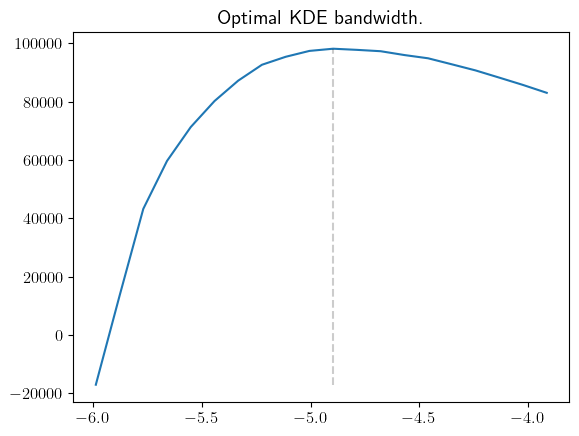

NameError: name 'train_set' is not defined

In [2]:
dataset = toy_dataset()
dataset.to('cuda')

# number of hidden units
nh = 100
# number of visible units
nv = dataset.n_features

rbm = RBM(nv=nv, 
          nh=nh,
          k=100,
          training='PCD',
          dataset = dataset,
          visible_normalized=True,
          lr=0.002,
          lr_trend='linear',
          bs=250,
          epochs=10000,
          print_step=100,
          verbose=True, 
          track_method=['KDE', 'MMD', 'NDB', 'rec_error'],
          track_learning=True)

# Train the RBM 
rbm.train(dataset)

# Save model in '/models'
filename = 'models/trained_model.pt'
rbm.save(filename=filename)